In [10]:
%matplotlib inline
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageFile
from urllib2 import urlopen
from django.core.validators import URLValidator
from django.core.exceptions import ValidationError
from sklearn.externals import joblib
from IPython.display import display



import keras
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from skimage.measure import compare_ssim
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding, Flatten, Dense, Lambda, Input, merge

# pip install opencv_python == 3.1.0.0
import cv2


# Helper Functions

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()


def is_url(url):
    val = URLValidator()
    try:
        val(url)
        return True
    except ValidationError as e:
        return False
    
def plot_channels(img):
    _ , ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(24, 6))
    plt.suptitle('RBG Channels of an Image', size=20)
    
    np_img_r = np_img.copy()
    np_img_r[:, :, 1] = np.zeros(shape=[img_height, img_width])
    np_img_r[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[0].imshow(np_img_r)
    ax[0].axis('off')
    
    np_img_g = np_img.copy()
    np_img_g[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_g[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[1].imshow(np_img_g)
    ax[1].axis('off')
    
    np_img_b = np_img.copy()
    np_img_b[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_b[:, :, 1] = np.zeros(shape=[img_height, img_width])
    ax[2].imshow(np_img_b)
    ax[2].axis('off')


def read_img_url(url):
    file = urlopen(url)

    img = Image.open(file)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def read_img_file(f):
    img = Image.open(f)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def read_img(f):
    if is_url(f):
        img = read_img_url(f)
    else:
        img = read_img_file(f)
    
    return img

def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

In [4]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

def make_resnet_conv(input_shape):
    '''
    Creates a ResNet50 model trained on ImageNet.
    It includes no final activation function,
    so model returns conv. features.
    
    `input_shape` is a tuple of integers.
    '''
    model = ResNet50(input_shape=input_shape, 
                     weights='imagenet', 
                     include_top=False)
    for layer in model.layers:
        layer.trainable = False   
    
    return model

In [5]:
def get_conv_feat(f, model):
    '''
    For any given image (file or url),
    convert to NumPy Array, resize to img_width x img_height,
    preprocess the values for ResNet, get the convolutional features
    from ResNet, and flatten the output.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    X_conv_2d = X_conv[0].flatten()
        
    return X_conv_2d

In [6]:
def get_conv_feats(f, model):
    '''
    Converts an image (str of path or url) to a 2d convolutional features AKA logit.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    new_shape = (X_conv.shape[0], np.prod(X_conv.shape[1:]))
    X_conv_2d = X_conv.reshape(new_shape)
    return X_conv_2d

In [7]:
# RUN FILE FROM HERE 
def get_neighbors(f, knn_file, top=8):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    
    X_conv_2d = get_conv_feats(f, model)
    neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
    delete_model(model)
    return neighbors

In [8]:
def plot_neighbors(url, neighbors, urls, top=8, per_row=4):
    CATEGORY_INDEX = 7  
    PRODUCT_ID = 8 
    path_split = url.split("/")
    query_category = path_split[7]
    distance = neighbors[0][0]
    
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    print "Query: ", query_category
    img = read_img(url) # reads an image link into a NumPy array...
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    imshow(np_img)
    
    c = 0 
    i = 0 
    product_recommended = []
    while (True):
        if c == top: break 
        if c % 4 == 0:
             _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(24, 6))
        j = c % 4

        k = neighbors[1][0][i]
        path = train_urls[k]
        J = train_urls[k].split("/")
        if not os.path.exists(path): 
            i += 1
            continue 
        image = read_img(path)
        if J[PRODUCT_ID] in product_recommended: 
            i += 1
            continue
        i += 1
        c += 1
        product_recommended.append(J[PRODUCT_ID])
        score = accuracy_score (query_category, J[CATEGORY_INDEX], top)
        ssim_s = ssim_score(url, train_urls[k]) * 100
        print ssim_s
        
        image = resize_img_to_array(image, img_shape=(img_width, img_height))
        ax[j].imshow(image)
        ax[j].axis('off')    
        ax[j].annotate(J[CATEGORY_INDEX] + "   MAP: "+ str(score * top)+ "  "+ "SSIM: "+ str(format(ssim_s, '.2f')) + "  d: "+ str(format(distance[i], '.2f')) ,
                      (0,0), (0, -32), xycoords='axes fraction', 
                       textcoords='offset points', va='top')

In [12]:
from keras.models import Model, load_model

In [14]:
ckpt = "2018-03-20-11-51-08.931087-bs_512-fd_512-lr_0.001-m_2.0-nl_3-ne_200-lf_triplet-am_standard.h5"
model = load_model(ckpt)
print("Loaded model!")

ValueError: bad marshal data (unknown type code)

# Extract embeddings for stock images

In [19]:
embeddings = pickle.load( open( "embeddings_4510.p", "rb" ) )

In [20]:
X_train_conv_2d = []
train_urls = []
datadir = '/Users/robelmengistu/Documents/CS230_project/'

for key in embeddings.keys():
    X_train_conv_2d.append(embeddings[key])
    train_urls.append(datadir + key)
print np.asarray(X_train_conv_2d).shape
print len(train_urls)

(4510, 2048)
4510


In [21]:
pickle.dump( train_urls, open( "train_urls.p", "wb" ) )

In [49]:
#Training KNN on 100K images w/ 2K features takes about 2 minutes!
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=20, n_jobs=8, algorithm='ball_tree')
knn.fit(X_train_conv_2d)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=8, n_neighbors=20, p=2, radius=1.0)

In [50]:
#serialize 
from sklearn.externals import joblib
knn_file = 'afronet_test_feats.pkl'
joblib.dump(knn, knn_file)

['afronet_test_feats.pkl']

# Load Extracted Features

In [22]:
knn_file = 'afronet_test_feats.pkl'
knn = joblib.load(knn_file)
train_urls = pickle.load( open( "train_urls.p", "rb" ) )

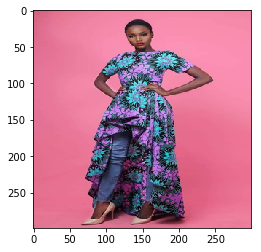

In [12]:
img_width, img_height = 299, 299
url = "/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/1MST6Z8Uafrikrea/01MST6Z8Uafrikrea.jpeg"
img = read_img(url)
n1p_img = resize_img_to_array(img, img_shape=(img_width, img_height))
imshow(n1p_img)

In [13]:
def accuracy_score (q_cat, r_cat, num_rec): 

    match_score =  1.0/num_rec
    half_match_score = (1.0/(num_rec * 2))
    
    matching_sets = [["women-dresses","women-outerwear", "women-matching-sets"], ["women-tops", "women-jackets"]]
    
    half_match_set_1 = ["women-jumpsuits", "women-pants-and-shorts","women-matching-sets","women-dresses", "women-skirts"]
    half_match_set_2 = ["women-tops", "women-jackets", "women-dresses", "women-matching-sets", "women-outerwear"]
    
    
    match_tuples = []
    for ms in matching_sets:
        for i in ms:
            for j in ms:
                if i != j: match_tuples.append((i,j))
    
    half_match_tuples = []
    for hs in [half_match_set_1, half_match_set_2]:
        for i in hs:
            for j in hs:
                if i != j: half_match_tuples.append((i,j))
    
    
    if r_cat == q_cat: return match_score
    if (r_cat, q_cat) in match_tuples: return match_score
    if (r_cat, q_cat) in half_match_tuples: return half_match_score
    return 0

In [14]:
def crop_image(imageA, dim = 100):
    # crop to center of image (450 x 450)
    
    
    width, height = imageA.size   # Get dimensions
   
   # new_width, new_height = width * 0.01 , height *  0.01
    left = (width - dim)/2
    top = (height - dim)/2
    right = (width + dim)/2
    bottom = (height + dim)/2

    im = imageA.crop((left, top, right, bottom))
    return im

def ssim_score(url, url_2): 
    query = Image.open(url, 'r')
    query_img = crop_image(query)
    neighbor = Image.open(url_2, 'r')
    neighbor_img = crop_image(neighbor)
    
    display(query_img, neighbor_img)
    
#     query_img.show()
#     neighbor_img.show()

    pix_val1 = np.array(list(query_img.getdata())) + 0.
    pix_val2 = np.array(list(neighbor_img.getdata())) + 0.
    return compare_ssim(pix_val1[:,2], pix_val2[:,2], win_size = 3)

def get_ssim_acc (url, n_urls):

    ssim_scores = []
    query = Image.open(url, 'r')
    query_img = crop_image(query)
    query_img.show()
    
    for url_n in n_urls:
        neighbor = Image.open(url_n, 'r')

        neighbor_img = crop_image(neighbor)
        #neighbor_img.show()
        #img2 = neighbor.resize(img1.size, Image.ANTIALIAS)
        
        pix_val1 = np.array(list(query_img.getdata())) + 0.
        pix_val2 = np.array(list(neighbor_img.getdata())) + 0.
        #print pix_val1, pix_val2
        ssim_scores.append(compare_ssim(pix_val1[:,2], pix_val2[:,2], win_size = 3))

    return ssim_scores  

In [15]:
# calc the mean avg. precision, returns neighbors
def get_map(url, neighbors, train_urls, num_rec=8, per_row=4):
    path_split = url.split("/")
    CATEGORY_INDEX = 7   
    PRODUCT_ID = 8 
    query_category = path_split[7]
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    c = 0 
    i = 0 
    MAP = 0 
    accuracy = [] 
    product_recommended = []
    rec_urls = []
    while (True):
        if c == num_rec: break 
        k = neighbors[1][0][i]
        J = train_urls[k].split("/")
        if not os.path.exists(train_urls[k]): 
            i += 1
            continue 
        if J[PRODUCT_ID] in product_recommended: 
            i += 1
            continue
        accuracy.append(accuracy_score(query_category, J[CATEGORY_INDEX], num_rec))
        rec_urls.append(train_urls[k])
        
        MAP += (sum(accuracy)/len(accuracy))
        
        i += 1
        c += 1
        product_recommended.append(J[PRODUCT_ID])
    
    
    return MAP, rec_urls
        

In [16]:
def get_neighbors_set(f_set, knn_file):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    neighbors_set = []
    for f in f_set: 
        X_conv_2d = get_conv_feats(f, model)
        neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
        neighbors_set.append(neighbors)
    delete_model(model)
    return neighbors_set

# Test Sanity on one image

In [17]:
sanity_url = "/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/1MST6Z8Uafrikrea/01MST6Z8Uafrikrea.jpeg"
sanity_neighbors = get_neighbors(sanity_url, knn_file, top=8)


In [18]:
MAP, rec_urls = get_map(sanity_url, sanity_neighbors, train_urls, num_rec=8, per_row=4)
print MAP
print get_ssim_acc (sanity_url, rec_urls)
plot_neighbors(sanity_url, sanity_neighbors, train_urls, top=8, per_row=4)

NameError: name 'train_urls' is not defined

In [217]:
#url_neighbors = get_neighbors(dresses_set[90], knn_file, top=8)


In [26]:
def test_sanity(url):
    url_neighbors = get_neighbors(url, knn_file, top=8)
    MAP, rec_urls = get_map(sanity_url, url_neighbors, train_urls, num_rec=8, per_row=4)
    print "MAP Score: ", MAP
    ssim_acc_s = get_ssim_acc (url, rec_urls)
    print ssim_acc_s
    print "Average SSIM: ", sum(ssim_acc_s)/len (ssim_acc_s)
    plot_neighbors(url, url_neighbors, train_urls, top=8, per_row=4)

MAP Score:  0.900818452381
[0.0066494827313566063, -0.010061002587567234, 0.0050675166836320219, 0.0082708694928922133, 0.011936251136994766, -0.0028631100368816296, 0.015284049585939447, 0.0096798628363536695]
Average SSIM:  0.00549548998034
Query:  women-dresses


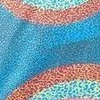

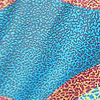

0.664948273136


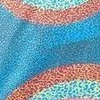

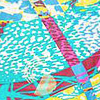

-1.00610025876


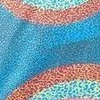

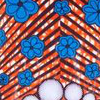

0.506751668363


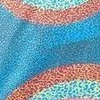

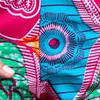

0.827086949289


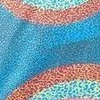

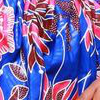

1.1936251137


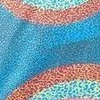

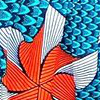

-0.286311003688


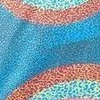

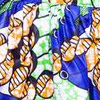

1.52840495859


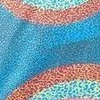

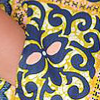

0.967986283635


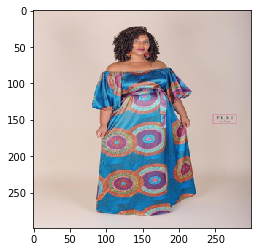

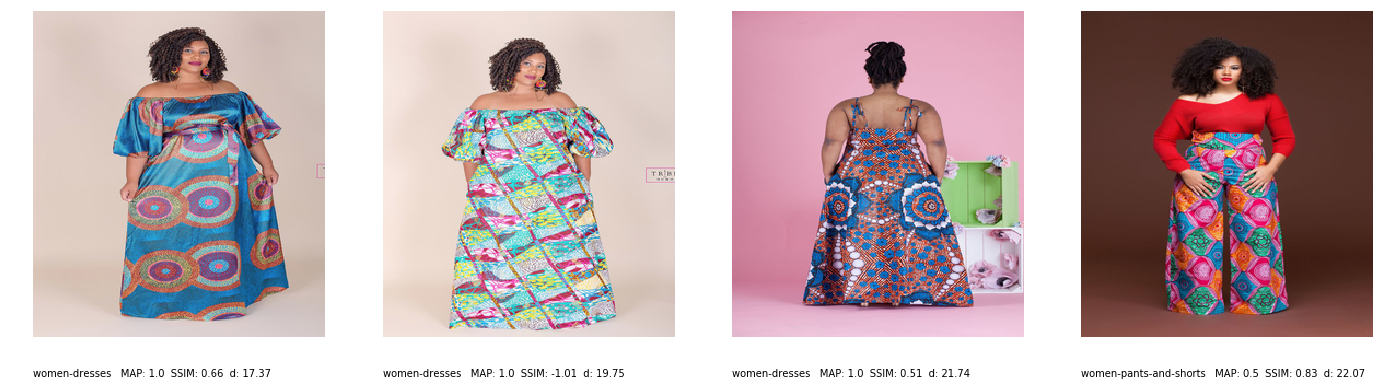

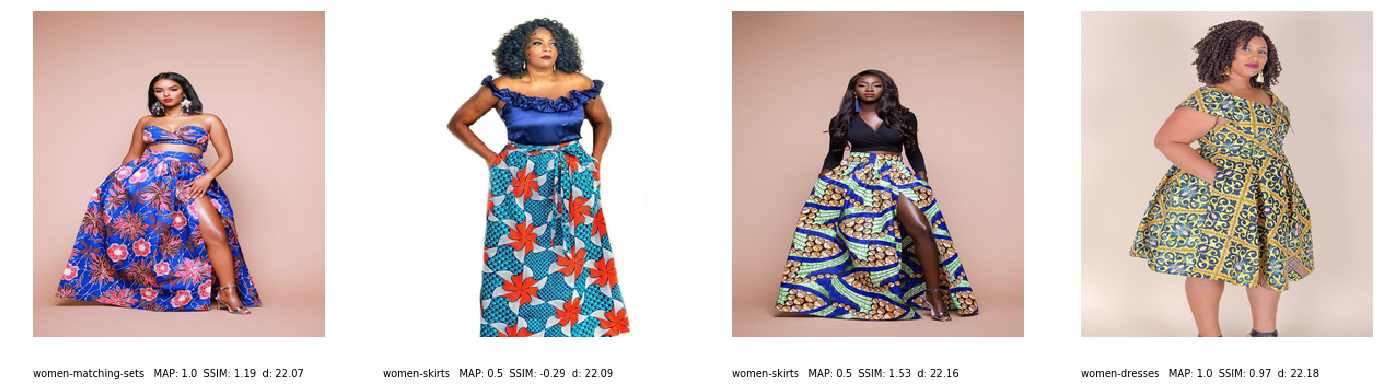

In [27]:
test_sanity(dresses_set[20])

In [24]:
CATEGORY = 6
PRODUCT_ID = 8
FILE_NAME = 9

datadir = '/Users/robelmengistu/Documents/CS230_project/data'
i = 0
products_added = []
test_urls = []

for subdir, dirs, files in os.walk(datadir):
    for img in files:
        if ".DS_" in img: continue
        path = subdir+"/" +img
        path_split = path.split("/")
        product = path_split[PRODUCT_ID]
        if "afrikrea" in product and product not in products_added:
            products_added.append(product)
            test_urls.append(path)
        else: 
            continue 
        i += 1
print len(test_urls)

4181


In [25]:
# Test Data
dresses_set = test_urls[:450]
other_set = test_urls[2750:3200]  # pants and shorts and skirts

In [241]:
for dset in dresses_set: 
    if "1UU53W6Qafrikrea" in dset: 
        print dresses_set.index(dset)

43


In [262]:
print dresses_set[43]

/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/1UU53W6Qafrikrea/01UU53W6Qafrikrea.jpeg


In [80]:
dress_neighbors_set = get_neighbors_set(dresses_set, knn_file)

In [81]:
other_neighbors_set = get_neighbors_set(other_set, knn_file)

In [234]:
print "TEST SET RESULTS: "
num_rec = 8
dress_accuracy = 0 
acc_factor = 1.0/len(dresses_set)
for i in range(len(dresses_set)):
    if i == 324: 
        dress_accuracy += (0.5*acc_factor)
        continue
    acc = get_map(dresses_set[i], dress_neighbors_set[i], X_train, num_rec=num_rec, per_row=4)
    #if acc < 0.2: print i
    dress_accuracy += (acc*acc_factor)

print "Dress MAP: ", dress_accuracy


other_accuracy = 0

acc_factor = 1.0/len(other_set)
for i in range(len(other_set)):
    acc = get_map(other_set[i], other_neighbors_set[i], X_train, num_rec=num_rec, per_row=4)
    other_accuracy += (acc*acc_factor)
    if acc < 0.2: print i
    
print "Other MAP: ", other_accuracy
print "Overall MAP", (other_accuracy + dress_accuracy)/2.0

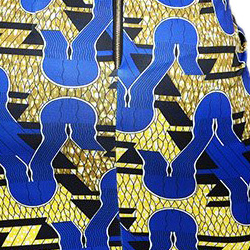

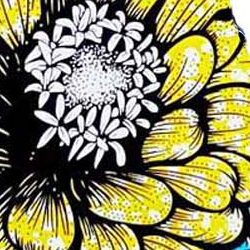

0.6691631244711954
None


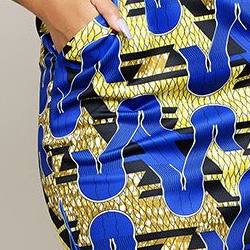

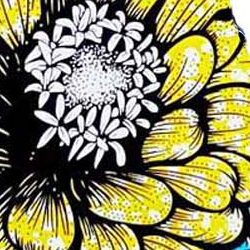

0.6408270330707049
None


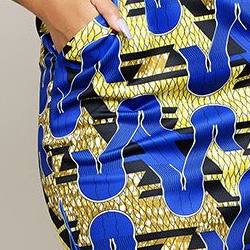

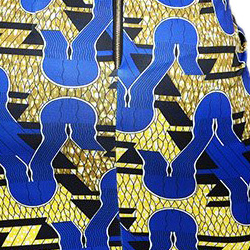

0.716927259889002
None


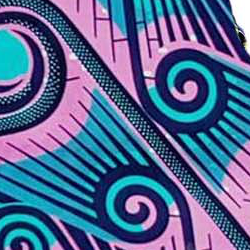

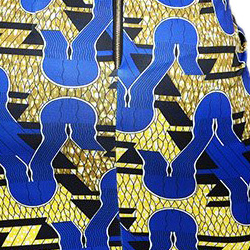

0.6905818060799309
None


In [369]:
url_1 = "/Users/robelmengistu/Desktop/vs1.jpg"
url_2 = "/Users/robelmengistu/Desktop/vs2.jpg"
url_3 = "/Users/robelmengistu/Desktop/vs3.jpeg"
url_4 = "/Users/robelmengistu/Desktop/vs4.jpg"

print color_similarity(url_1, url_2)
print color_similarity(url_1, url_3)
print color_similarity(url_2, url_3)
print color_similarity(url_2, url_4)

In [32]:
url_1 = "/Users/robelmengistu/Desktop/test_imgs/v1.jpeg"
url_2 = "/Users/robelmengistu/Desktop/test_imgs/v2.jpeg"
url_3 = "/Users/robelmengistu/Desktop/test_imgs/v3.jpeg"
url_4 = "/Users/robelmengistu/Desktop/test_imgs/v4.jpeg"
url_5 = "/Users/robelmengistu/Desktop/test_imgs/v5.jpeg"


print color_similarity(url_1, url_3)
print color_similarity(url_3, url_3)
print color_similarity(url_4, url_3)
print color_similarity(url_2, url_3)

(-0.06884651813364125, 111132358.82879852)
(1.0, 0.0)
(0.8997640323628567, 4005744.0627920334)
(-0.06739991438755774, 157532190.79426354)


In [31]:
#calculating similarity based on color
from PIL import Image, ImageFile
from skimage.measure import compare_ssim
import cv2
from indicoio import image_features, config
from scipy import spatial
import indicoio

indicoio.config.api_key = 'c9889952c9a2d44cb839932b09160b7b'    


# def color_similarity(url, input_url):
    
#     neighbor = Image.open(url, 'r')
#     orig = Image.open(input_url, 'r')
#     crop_dim = max(min(min(orig.size), min(neighbor.size))* 0.2, 20)
    
#     img1 = crop_image(orig, crop_dim)
#     img2 = crop_image(neighbor, crop_dim)
#     #img2.show()
#     #img2 = neighbor.resize(img1.size, Image.ANTIALIAS)

#     display(img1, img2)

#     pix_val1 = np.array(list(img1.getdata())) + 0.
#     pix_val2 = np.array(list(img2.getdata())) + 0.

#     features_1 = image_features(input_url)
#     features_2 = image_features(url)
#     similarity = 1 - spatial.distance.cosine(pix_val1.flatten(), pix_val2.flatten())  # This is what you want
#     print similarity
    
def color_similarity(url, url2):
    
#     neighbor = Image.open(url, 'r')
#     orig = Image.open(input_url, 'r')
#     crop_dim = max(min(min(orig.size), min(neighbor.size))* 0.2, 200)
    
#     img1 = crop_image(orig, crop_dim)
#     img2 = crop_image(neighbor, crop_dim)
    
    img1 = cv2.imread(url)
    img1= cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    hist1 = cv2.calcHist([img1], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    #hist1 = cv2.normalize(hist1).flatten()
    
    
    img2 = cv2.imread(url2)
    img2= cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    hist2 = cv2.calcHist([img2], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    #hist2 = cv2.normalize(hist2).flatten()
    
    d = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    d2 = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    
#     im1 = Image.open(url, 'r')
#     im2 = Image.open(url2, 'r')
#     im1 = crop_image(im1, )
#     im2 = crop_image(im2)
#     display(im1, im2)

    return d, d2
    #img2.show()
    #img2 = neighbor.resize(img1.size, Image.ANTIALIAS)

    

#     pix_val1 = np.array(list(img1.getdata())) + 0.
#     pix_val2 = np.array(list(img2.getdata())) + 0.

#     features_1 = image_features(input_url)
#     features_2 = image_features(url)
#     similarity = 1 - spatial.distance.cosine(pix_val1.flatten(), pix_val2.flatten())  # This is what you want
#     print similarity